In [5]:
import numpy as np
import random
import pandas as pd
import csv

'''==================================================
Initial set up
=================================================='''
def init():
    #Hyperparameters
    SMALL_ENOUGH = 0.005
    GAMMA = 0.9         
    NOISE = 0.1

    #Define all states
    all_states=[]
    for i in range(4):
        for j in range(6):
                all_states.append((i,j))

    #Define rewards for all states
    rewards = {}
    for i in all_states:
        if i == (1,5):
            rewards[i] = 1
        elif i == (3,4):
            rewards[i] = -1
        elif i == (3,5):
            rewards[i] = -1
        else:
            rewards[i] = 0

    #Dictionnary of possible actions. We have three "end" states (1,5 and 3,4 and 3,5)
    actions = {
        (0,0):('D', 'R'), 
        (0,1):('D', 'R', 'L'),    
        (0,2):('D', 'L', 'R'),
        (0,3):('D', 'L', 'R'),
        (0,4):('D', 'L', 'R'),
        (0,5):('D', 'L'),
        (1,0):('D', 'U', 'R'),
        (1,1):('D', 'R', 'L', 'U'),
        (1,2):('D', 'R', 'L', 'U'),
        (1,3):('D', 'R', 'L', 'U'),
        (1,4):('D', 'R', 'L', 'U'),
        (2,0):('D', 'U', 'R'),
        (2,1):('D', 'R', 'L', 'U'),
        (2,2):('D', 'R', 'L', 'U'),
        (2,3):('D', 'R', 'L', 'U'),
        (2,4):('D', 'R', 'L', 'U'),
        (2,5):('D', 'L', 'U'),
        (3,0):('U', 'R'),
        (3,1):('R', 'L', 'U'),
        (3,2):('R', 'L', 'U'),
        (3,3):('R', 'L', 'U'),
        } #I'm not sure if this will work but its certainly a better organization of data

    #Define an initial policy
    policy={}
    for s in actions.keys():
        policy[s] = np.random.choice(actions[s])

    #Define initial value function 
    V={}
    for s in all_states:
        if s in actions.keys():
            V[s] = 0
        if s ==(3,4):
            V[s]= -1
        if s == (3,5):
            V[s]= -1
        if s == (1,5):
            V[s]= 1


    start = [0]*24
    row = [(0,0),(0,1),(0,2),(0,3),(0,4),(0,5),(1,0),(1,1),(1,2),(1,3),(1,4),(1,5),(2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(3,0),(3,1),(3,2),(3,3),(3,4),(3,5)]
    transition = { 
        tuple((0,0)):[], 
        tuple((0,1)):[],    
        tuple((0,2)):[],
        tuple((0,3)):[],
        tuple((0,4)):[],
        tuple((0,5)):[],
        tuple((1,0)):[],
        tuple((1,1)):[],
        tuple((1,2)):[],
        tuple((1,3)):[],
        tuple((1,4)):[],
        tuple((1,5)):[],
        tuple((2,0)):[],
        tuple((2,1)):[],
        tuple((2,2)):[],
        tuple((2,3)):[],
        tuple((2,4)):[],
        tuple((2,5)):[],
        tuple((3,0)):[],
        tuple((3,1)):[],
        tuple((3,2)):[],
        tuple((3,3)):[],
        tuple((3,4)):[],
        tuple((3,5)):[],
        }
    return rewards, actions, policy, V, transition
#By the end of this, the grid, values, transitional model, and rewards have been set up
#An initial policy has been established, which I guess will be a part of the actions taken


In [6]:

def one_trial(actions,V,policy):
    Terminal = False
    trial_list = []
    start=random.choice([(0,0),(2,1)])
    state = start
    trial_list.append(state)

    while not Terminal:
        #choose an action randomly from the permissible actions
        probs = random.choice([0,1,2])
        if probs > 3:
            a = policy[state]
        else:
            a = random.choice(actions[state]) #Totally wacky, but I can make it go from a policy somewhat
        #The result of this block needs to be a = action

        ex = state[0]
        why = state[1]
        if a == 'U':
            nxt = (ex-1, why)
        if a == 'D':
            nxt = (ex+1, why)
        if a == 'L':
            nxt = (ex, why-1)
        if a == 'R':
            nxt = (ex, why+1)
        trial_list.append(nxt)

        #now, a random state has been chosen and the next state established
        value = V[nxt]

        if value == 1:
            Terminal = True
            break
        elif value == -1:
            Terminal = True
            break
        state = nxt
    return trial_list

def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices


def define_transition_model(row, transition_model, trials):
    #Scanning (s,a,s')
    for g in row:
        s = g #The state we
        for i in transition_model:
            s_prime = i #Chossing column
            N = 0 #Everytime the column shifts, everything should revert
            N_all = 0
            for h in trials:
                num_inst = find_indices(h,g) #Number of times s was in a trial, for which the list of trials is iterated through
                N_all += len(num_inst) #This then represents how many times we went from S to anywhere, including s' or otherwise
                for m in num_inst:
                    if m+1 < len(h):
                        actual_s_prime = h[m+1] #What is the actual next item after every instance of S
                    else:
                        actual_s_prime = None
                    if actual_s_prime == s_prime: #in the column we're 
                        N +=1 #Number of times in any trial that s came before s prime
            #Now we have N and N_all, now we need to input N/ N_all into the proper space in the transition model
            column = row.index(g)
            if N_all != 0:
                transition_model[tuple(i)].append(N/ N_all) #This should work bc we're iterating through g in order
            else:
                transition_model[tuple(i)].append(0)
    return transition_model

#Now to create a policy from the value iteration results
def create_policy(policy, actions,states,df):
    for j in policy:
        options = actions[j]
        ex = j[0]
        why = j[1]
        nxtU = 0
        nxtD = 0
        nxtL = 0
        nxtR = 0
        valU = 0
        valD = 0
        valL = 0
        valR = 0
        maxVal = 0
        arrow = '?' #Default, go up bc you've gone lower into an undefined state
        for a in options: #Grabbing all surrounding states
            if a == 'U':
                nxtU = (ex-1, why)
                indx = states.index((ex-1,why))
                valU = df.iat[indx,0]
                if valU > maxVal:
                    maxVal = valU
                    arrow = 'U'
            if a == 'D':
                nxtD = (ex+1, why)
                indx = states.index((ex+1,why))
                valD = df.iat[indx,0]
                if valD > maxVal:
                    maxVal = valU
                    arrow = 'D'
            if a == 'L':
                nxtL = (ex, why-1)
                indx = states.index((ex,why-1))
                valL = df.iat[indx,0]
                if valL > maxVal:
                    maxVal = valU
                    arrow = 'L'
            if a == 'R':
                nxtR = (ex, why+1)
                indx = states.index((ex,why+1))
                valR = df.iat[indx,0]
                if valR > maxVal:
                    maxVal = valR
                    arrow = 'R'
            #Now that the highest value next step has been found, the policy should be adjusted
            policy[j] = arrow
    return policy

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_value_policy(policy, num_rows, num_cols, reward, fig_size=(8, 6)):
    file = open("C:\\Users\\sophi\\VS Code Projects\\ReinforcementLearning\\ByHand\\GridWorld.csv")
    unit = min(fig_size[1] // num_rows, fig_size[0] // num_cols)
    unit = max(1, unit)
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.axis('off')

    for i in range(num_cols + 1):
        if i == 0 or i == num_cols:
            ax.plot([i * unit, i * unit], [0, num_rows * unit],
                    color='black')
        else:
            ax.plot([i * unit, i * unit], [0, num_rows * unit],
                    alpha=0.7, color='grey', linestyle='dashed')
    for i in range(num_rows + 1):
        if i == 0 or i == num_rows:
            ax.plot([0, num_cols * unit], [i * unit, i * unit],
                    color='black')
        else:
            ax.plot([0, num_cols * unit], [i * unit, i * unit],
                    alpha=0.7, color='grey', linestyle='dashed')
    for i in range(num_rows):
        for j in range(num_cols):
            y = (num_rows - 1 - i) * unit
            x = j * unit
            if (i,j) in policy:
                a = policy[(i,j)]
                symbol = ['^', '>', 'v', '<','x']
                if a == 'U':
                    sym = symbol[0]
                if a == 'D':
                    sym = symbol[2]
                if a == 'L':
                    sym = symbol[3]
                if a == 'R':
                    sym = symbol[1]
                if a == '?':
                    sym = symbol[4]
                ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=sym,
                                    linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')
            elif reward[(i,j)] == 1:
                rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                            alpha=0.6)
                ax.add_patch(rect)
            elif reward[(i,j)] == -1:
                rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                            alpha=0.6)
                ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


def val_and_pol_update(trials,V, transition, actions, rewards, policy):
    row = [(0,0),(0,1),(0,2),(0,3),(0,4),(0,5),(1,0),(1,1),(1,2),(1,3),(1,4),(1,5),(2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(3,0),(3,1),(3,2),(3,3),(3,4),(3,5)]
    transition_update = define_transition_model(row,transition, trials)

    DF_transition = pd.DataFrame(transition_update, index=row)
    DF_transition.to_csv("transition.csv")

    value_list = []
    reward_list = []
    states = []
    for j in V:
        dataV = V[j]
        dataR = rewards[j]
        value_list.append(dataV)
        reward_list.append(dataR)
        states.append(j) #to keep track of which states we visited
            
    trans_array = DF_transition.values

    num_row = len(value_list)
    value_array = np.array(value_list)
    val_arr = np.reshape(value_array,(num_row,1))
    reward_array = np.array(reward_list)
    rew_arr = np.reshape(reward_array,(num_row,1))


    #V = R + Gamma*P*V
    # R = V - Gamma*P*V
    #Have to put it in the format of ax = b and the solution is x
    #R = [[1x24] - Gamma*P]V 
    #Here, b =R, x = V, and a = [I[24x24] - Gamma*P*I[24x24]]
    B = rew_arr
    gamma = 0.9
    inv = np.identity(24)
    A = inv - (gamma*np.matmul(trans_array,inv))

    det = np.linalg.det(A)
    x = np.linalg.solve(A,B)


    df = pd.DataFrame(x, index=states)

    policy = create_policy(policy, actions,states,df)

    for i in states:
        indx = states.index(i)
        V[i] = df.iat[indx,0]

    return policy, V, actions, transition, rewards


In [7]:


rewards, actions, policy, V, transition = init()

class_example = False

f = open("C:\\Users\\sophi\\VS Code Projects\\ReinforcementLearning\\ByHand\\trials.csv", 'w', newline='')
writer = csv.writer(f)

#First set of trials
if class_example: #I'll have to set many other things to make this the case
    #For testing against class example
    trials = [0]*3
    V[(2,1)] = -1
    V[(2,2)] = 1
    rewards[(2,1)] = -1
    rewards[(2,2)] = 1

    
    trials[0] = [(0,0),(0,1),(0,2),(1,2),(2,2)]
    trials[1] = [(0,0),(0,1),(1,1),(0,1),(0,2),(1,2),(2,2)]
    trials[2] = [(0,0),(1,0),(0,0),(0,1),(0,2),(1,2),(2,2)]
else:
    trials = [0]*20
    trials[0] = one_trial(actions,V, policy)
    writer.writerow(trials[0])
    trials[1]  = one_trial(actions,V,policy)
    writer.writerow(trials[1])
    trials[2]  = one_trial(actions,V,policy)
    writer.writerow(trials[2])
    trials[3]  = one_trial(actions,V,policy)
    writer.writerow(trials[3])
    trials[4]  = one_trial(actions,V,policy)
    writer.writerow(trials[4])
    trials[5] = one_trial(actions,V, policy)
    writer.writerow(trials[5])
    trials[6]  = one_trial(actions,V,policy)
    writer.writerow(trials[6])
    trials[7]  = one_trial(actions,V,policy)
    writer.writerow(trials[7])
    trials[8]  = one_trial(actions,V,policy)
    writer.writerow(trials[8])
    trials[9]  = one_trial(actions,V,policy)
    writer.writerow(trials[9])
    trials[10]  = one_trial(actions,V,policy)
    writer.writerow(trials[10])
    trials[11]  = one_trial(actions,V,policy)
    writer.writerow(trials[11])
    trials[12]  = one_trial(actions,V,policy)
    writer.writerow(trials[12])
    trials[13]  = one_trial(actions,V,policy)
    writer.writerow(trials[13])
    trials[14]  = one_trial(actions,V,policy)
    writer.writerow(trials[14])
    trials[15]  = one_trial(actions,V,policy)
    writer.writerow(trials[15])
    trials[16]  = one_trial(actions,V,policy)
    writer.writerow(trials[16])
    trials[17]  = one_trial(actions,V,policy)
    writer.writerow(trials[17])
    trials[18]  = one_trial(actions,V,policy)
    writer.writerow(trials[18])
    trials[19]  = one_trial(actions,V,policy)
    writer.writerow(trials[19])



    #DF_trials = pd.DataFrame(trials)
    #DF_trials.to_csv("trials.csv")

    
policy, V, actions, transition, rewards = val_and_pol_update(trials,V, transition, actions, rewards, policy)

f.close()

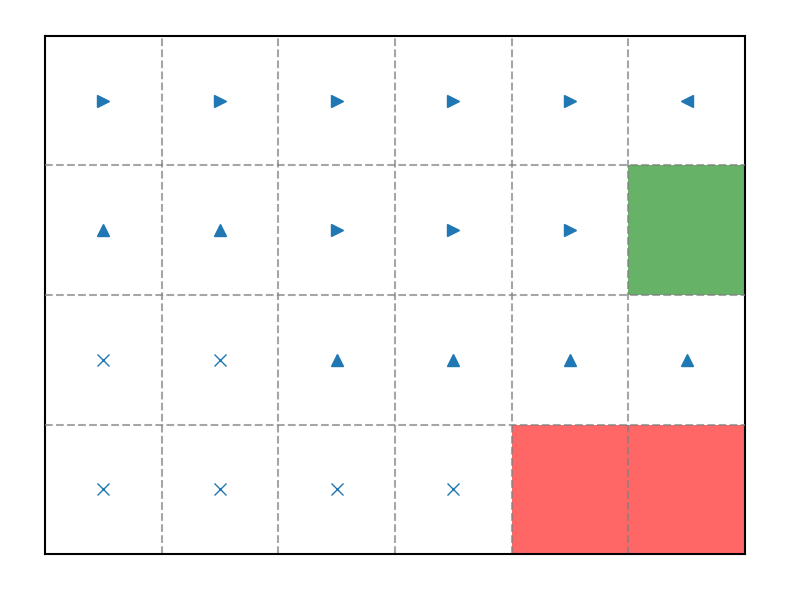

In [8]:

visualize_value_policy(policy,4,6,rewards)